# 1. 구글 드라이브 연동
Google Colab을 사용하므로 데이터를 구글 드라이브에 올렸다.<br>
따라서 데이터를 사용하기 위해 구글 드라이브와 연동한다.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 2. 데이터 전처리 및 데이터 셋 설정
사진의 크기(픽셀)가 같아야 각 층의 커널을 통과한 후 
출력 벡터의 크기가 같아지는데 사진의 크기가 모두 다르다.<br>
따라서, 사진의 픽셀을 224*224 로 바꾼다.<br>
(구글 드라이브에서 변경하려고 하니 오래걸려서 로컬에서 미리 사진의 크기를 바꾸는 전처리를 했다.)<br>
<br>
그리고 데이터를 각각 training set과 test set으로 나눈다.<br>

In [0]:
from PIL import Image
import os, glob, numpy as np

caltech_dir = "/content/gdrive/My Drive/shuffled_chest_xray2/"
categories = ["NORMAL", "PNEUMONIA"]
nb_classes = len(categories)

image_w = 224
image_h = 224

pixels = image_h * image_w * 3

X_train = []
y_train = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "train/" + cat
    files = glob.glob(image_dir+"/*.jpeg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
      img = Image.open(f)
      img = img.convert("RGB")
      img = img.resize((image_w, image_h))
      data = np.asarray(img)

      X_train.append(data)
      y_train.append(label)

      if i % 200 == 0:
        print(cat, i, "/", len(files), " : ", f)
    

X_train = np.array(X_train)
y_train = np.array(y_train)
# 셔플
shuf = np.arange(X_train.shape[0])
np.random.shuffle(shuf)

X_train = X_train[shuf]
y_train = y_train[shuf]

X_test = []
y_test = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "test/" + cat
    files = glob.glob(image_dir+"/*.jpeg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X_test.append(data)
        y_test.append(label)

        if i % 200 == 0:
            print(cat, i, "/", len(files), " : ", f)

X_test = np.array(X_test)
y_test = np.array(y_test)
# 셔플
shuf = np.arange(X_test.shape[0])
np.random.shuffle(shuf)

X_test = X_test[shuf]
y_test = y_test[shuf]

xy = (X_train, y_train, X_test, y_test)
print("change sets to list ok")
np.save("/content/gdrive/My Drive/np/shuffled_data2.npy", xy)
print("총 파일 수: ", len(y_train)+len(y_test))

NORMAL  파일 길이 :  4572
NORMAL 0 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00022390_000.jpeg
NORMAL 200 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00024527_000.jpeg
NORMAL 400 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00026181_004.jpeg
NORMAL 600 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00027912_005.jpeg
NORMAL 800 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00029840_000.jpeg
NORMAL 1000 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00015561_008.jpeg
NORMAL 1200 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00016861_002.jpeg
NORMAL 1400 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00018027_005.jpeg
NORMAL 1600 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/00019363_004.jpeg
NORMAL 1800 / 4572  :  /content/gdrive/My Drive/shuffled_chest_xray2/train/NORMAL/000

# 3. 필요한 모듈 임포트
딥러닝 모델을 설계할 때 필요한 모듈들을 임포트 한다.<br>
그리고 2번에서 전처리한 데이터를 불러온다.<br>
데이터가 잘 섞여있나 확인을 위해 test set의 y값을 출력해본다.

In [2]:
%tensorflow_version 1.x

import os, glob, numpy as np
import PIL
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization, ZeroPadding2D, InputLayer, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, y_train, X_test, y_test= np.load("/content/gdrive/My Drive/np/shuffled_data2.npy", allow_pickle = True)
print("is shuffled?: ")
print(y_test[:20])
print("training set shape: " + str(X_train.shape))
print("training set size: " + str(X_train.shape[0]))

Using TensorFlow backend.


is shuffled?: 
[[1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
training set shape: (9135, 224, 224, 3)
training set size: 9135


# 4. RGB 값 일반화
RGB 값은 0\~255의 크기를 가지는데<br>
학습하기 위해선 0~1의 크기이어야 한다.<br>
따라서 크기를 바꿔준다.

In [0]:
categories = ["NORMAL", "PNEUMONIA"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

# 5. 모델 설계
다양한 모델을 설계하여 테스트 해본다.<br>
전이 학습(transfer learning) 방식으로 VGG16, Inception V3, Resnet50을 사용하여 특징 추출을 하고, 평균풀링으로 분류기를 붙였다.<br>
따라서 특징 추출부분은 가중치가 변하지 않고, 분류기 부분만 학습하도록 만들었다.<br>
아래의 코드는 세 가지 전이 학습에서 사용할 모듈을 임포트하고,
특징 추출시 사용할 함수이다.

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50

def get_features(extractor, X, y):
    extractor_shapes = list(extractor.get_output_shape_at(0)[1:])

    features = extractor.predict(X)
    labels = y
    
    return features, labels

## 5.1.1 VGG16 전이 학습
with 라인은 GPU를 사용하기 위한 코드다.<br>
특징 추출기로 VGG16을 사용했다.

In [0]:
with K.tf_ops.device('/device:GPU:0'):
  extractor = Sequential()
  extractor.add(VGG16(include_top=False, weights='imagenet', input_shape=X_train.shape[1:]))

  extractor_output_shape = extractor.get_output_shape_at(0)[1:]

  trainX, trainY = get_features(extractor, X_train, y_train)
  testX, testY = get_features(extractor, X_test, y_test)

아래의 코드는 분류기 코드로서, 특징 추출기와 연결되도록 만들어져 있다.
validation loss값이 가장 낮은 것을 최종 모델의 형태로 하는데<br>
학습 중 local optimum에 빠지는 것을 방지하기 위해<br>
현재 가장 낮은 val_loss 값보다 큰 loss 값이 나와도 7번까지 더 학습을 수행한다.<br>
7번까지 더 낮은 loss 값이 나오지 않으면 저장하고 있던 가장 낮은 loss 값으로 모델을 정의한다.<br>
각각의 특징 추출기마다 출력 모양이 다른 것을 확인할 수 있다.

전이 학습 종류마다 같은 코드가 들어간다.

In [101]:
with K.tf_ops.device('/device:GPU:0'):
  model = Sequential()
  print(extractor_output_shape)
  model.add(layers.InputLayer(input_shape=extractor_output_shape))
  model.add(layers.GlobalAveragePooling2D()) # 2
  model.add(layers.Dense(2, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # 분류할 클래스가 3개 이상이면 categorical_crossentropy
  model_dir = '/content/gdrive/My Drive/model'

  if not os.path.exists(model_dir):
    os.mkdir(model_dir)

  model_path = model_dir + '/Xray_img_classification.model'
  checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=7)

(7, 7, 512)


## 5.1.2 VGG16 전이 학습 모델 형태
위가 특징 추출기인 VGG16이고, 아래가 분류기다.

In [97]:
extractor.summary()
print("\n\n")
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________



Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 1026      
Total params: 1

## 5.2.1 Inception V3 전이 학습
특징 추출기로 Inception V3를 사용했다.<br>

In [0]:
with K.tf_ops.device('/device:GPU:0'):
  extractor = Sequential()
  extractor.add(InceptionV3(include_top=False, weights='imagenet', input_shape=X_train.shape[1:]))

  extractor_output_shape = extractor.get_output_shape_at(0)[1:]

  trainX, trainY = get_features(extractor, X_train, y_train)
  testX, testY = get_features(extractor, X_test, y_test)

In [110]:
with K.tf_ops.device('/device:GPU:0'):
  model = Sequential()
  print(extractor_output_shape)
  model.add(layers.InputLayer(input_shape=extractor_output_shape))
  model.add(layers.GlobalAveragePooling2D()) # 2
  model.add(layers.Dense(2, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # 분류할 클래스가 3개 이상이면 categorical_crossentropy
  model_dir = '/content/gdrive/My Drive/model'

  if not os.path.exists(model_dir):
    os.mkdir(model_dir)

  model_path = model_dir + '/Xray_img_classification.model'
  checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=7)

(5, 5, 2048)


## 5.2.2 Inception V3 전이 학습 모델 형태
위가 특징 추출기인 Inception V3이고, 아래가 분류기다.<br>
모델 형태는 5.1.2번의 모델의 형태에서 특징 추출기만 변한 것이다.

In [111]:
extractor.summary()
print("\n\n")
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________



Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 2048)              104859648 
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 4098      
Total para

## 5.3 ResNet50 전이 학습
특징 추출기로 ResNet50을 사용했다.<br>
모델 형태는 5.1.2번의 모델의 형태에서 특징 추출기만 변한 것이다.
아래의 코드는 특징 추출기를 정의한 것이다.

In [5]:
with K.tf_ops.device('/device:GPU:0'):
  extractor = Sequential()
  extractor.add(ResNet50(include_top=False, weights='imagenet', input_shape=X_train.shape[1:]))

  extractor_output_shape = extractor.get_output_shape_at(0)[1:]

  trainX, trainY = get_features(extractor, X_train, y_train)
  testX, testY = get_features(extractor, X_test, y_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 1s 0us/step


In [6]:
with K.tf_ops.device('/device:GPU:0'):
  model = Sequential()
  print(extractor_output_shape)
  model.add(layers.InputLayer(input_shape=extractor_output_shape))
  model.add(layers.GlobalAveragePooling2D()) # 2
  model.add(layers.Dense(2, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # 분류할 클래스가 3개 이상이면 categorical_crossentropy
  model_dir = '/content/gdrive/My Drive/model'

  if not os.path.exists(model_dir):
    os.mkdir(model_dir)

  model_path = model_dir + '/Xray_img_classification.model'
  checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=7)

(7, 7, 2048)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 5.3.2 ResNet50 전이 학습 모델 형태
위가 특징 추출기인 ResNet50이고, 아래가 분류기다.<br>
모델 형태는 5.1.2번의 모델의 형태에서 특징 추출기만 변한 것이다.

In [7]:
extractor.summary()
print("\n\n")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 4,098
Trainable params: 4,098
Non-trainable params: 0
_________________________________________________________________


# 6. 학습 및 학습과정 저장
모델을 학습시키고 학습과정을 그래프로 나타내기 위해 학습과정을 저장한다.<br>
학습 중에 training set의 일부(20%)를 validation set으로 이용하여 평가한다.<br>
(밑의 실행한 fit은 ResNet50을 사용한 전이 학습 코드다.)

In [8]:
history = model.fit(trainX, trainY, batch_size=64, epochs=1000, validation_split=0.2, shuffle=True, callbacks=[checkpoint, early_stopping])

Train on 7308 samples, validate on 1827 samples
Epoch 1/1000
7232/7308 [============================>.] - ETA: 0s - loss: 0.6927 - acc: 0.5304
Epoch 00001: val_loss improved from inf to 0.68216, saving model to /content/gdrive/My Drive/model/Xray_img_classification.model
7308/7308 [==============================] - 26s 4ms/sample - loss: 0.6928 - acc: 0.5295 - val_loss: 0.6822 - val_acc: 0.5520
Epoch 2/1000
7104/7308 [============================>.] - ETA: 0s - loss: 0.6762 - acc: 0.6006
Epoch 00002: val_loss improved from 0.68216 to 0.67894, saving model to /content/gdrive/My Drive/model/Xray_img_classification.model
7308/7308 [==============================] - 2s 320us/sample - loss: 0.6768 - acc: 0.5975 - val_loss: 0.6789 - val_acc: 0.5172
Epoch 3/1000
7232/7308 [============================>.] - ETA: 0s - loss: 0.6683 - acc: 0.6356
Epoch 00003: val_loss improved from 0.67894 to 0.66514, saving model to /content/gdrive/My Drive/model/Xray_img_classification.model
7308/7308 [========

# 7. 모델 테스트
test set으로 모델의 성능을 테스트 한다.

In [9]:
print("정확도 : %.4f" % (model.evaluate(testX, testY)[1]))

2282/2282 [==============================] - 1s 265us/sample - loss: 0.4029 - acc: 0.8339
정확도 : 0.8339


# 8. 학습 과정
모델의 학습 과정을 그래프로 도사한다.<br>
train_loss는 점점 감소하지만 val_loss는 어느 순간 잘 감소하지 않고 오히려 증가하는 것을 볼 수 있다.<br>
따라서 overfitting이 일어나기 전에 checkpoint에서 학습을 중지한 것을 볼 수 있다.<br>
(밑의 그래프는 ResNet50을 사용한 전이 학습 과정이다.)

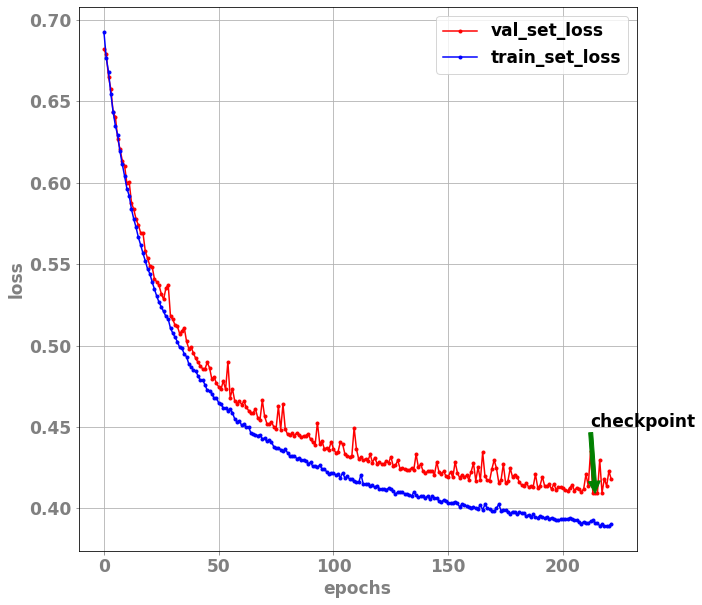

In [10]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))

font = {'weight' : '600',
        'size'   : 17}
plt.rc('font', **font)
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'grey'
plt.rcParams['axes.labelweight'] = '600'
plt.rcParams['xtick.color'] = 'grey'
plt.rcParams['ytick.color'] = 'grey'
plt.figure(figsize=(10, 10))
plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.annotate('checkpoint',xy=(len(y_vloss)-8,y_vloss[len(y_vloss)-8]),xytext=(len(y_vloss)-10,y_vloss[len(y_vloss)-8]*1.1),arrowprops={'color':'green'},)
plt.show()

# 9. Review
폐렴 사진은 5704장 뿐인데 정상 사진은 약 6만개가 넘었다.<br>
따라서 랜덤하게 정상 사진에서 5704개의 사진을 두 그룹으로 뽑았다.(A그룹, B그룹)<br>
정상, 폐렴 각각 5704장의 사진중에서 랜덤하게 20%(1141장)의 사진을 test set을 위해 분리했다.<br>
A그룹의 정상 사진과 폐렴 사진을 사용한 모델은 평균적으로 88%의 정확도를 나타냈다.<br>
B그룹의 정상 사진과 폐렴 사진을 사용한 모델은 평균적으로 85%의 정확도를 나타냈다.<br>
모델의 평균 정확도는 약 86% 정도로 볼 수 있으므로 꽤 유능한 분류 성능을 보여준다.<br>
<br>
기존 분류모델인 VGG16, Inception V3, ResNet50을 특징 추출기로 사용하여 전이 학습(transfer learning)을 해봤지만<br> 
오히려 성능은 낮게 나왔다.(전이 학습을 한 모델이 비슷한 정확도지만 loss값이 더 높았다)<br>
따라서 직접 설계한 간단한 CNN 모델이 더 좋다고 생각한다.<br>
<br>
### 전이 학습에 히트맵이 없는 이유
히트맵을 만들려면 특징 추출의 마지막 층을 분류기의 출력 층으로 미분하여 gradients 값을 구해야 되는데,<br>
전이 학습을 사용한 모델은 특징 추출기가 가중치를 동결시키고 분류기와 연결시켜서<br> 
두 layer사이에 gradients가 연관되어있지 않아서 히트맵을 만들 수 없었다.